# Welcome to the Forward Simulation tutorial
In this tutorial, we will bring together all the knowledge you have acquired so far and guide you through running your first model. This involves creating a fracture geometry, creating an antenna configuration for the source and receivers, setting up your source function and running the forward simulation. We will also show you how to visualize the geometry configuration and the results of the simulation. 
### Contents:
1. [Create a source function](#1)
2. [Create a simple geometry](#2)
3. [Create an antenna geometry](#3)
4. [Visualize the geometry configuration](#4)
5. [Setup the parameters for the forward simulation](#5)
6. [Time zero correction](#6)
7. [Run the forward simulation](#7)
8. [Check results](#8)
9. [Save the results](#9)

In [1]:
# Import all the important pakages
from fracwave import FractureGeo, Antenna, SourceEM, FracEM, OUTPUT_DIR
import numpy as np
import matplotlib.pyplot as plt


2023/11/22 12:52:37 PM | INFO     | CuPy not installed
No module named 'osgeo'
2023/11/22 12:52:38 PM | WARNING  | Using Gempy version 2.3.1. Please consider upgrading to Gempy V3.0 or higher to avoid this warning


## 1. Create a source function <a class="anchor" id="1"></a>
It's crucial to define a source function as it directly impacts the required element size in your simulation. The characteristics of the source function will influence the level of detail necessary to achieve accurate results. Hence, understanding and specifying the source function is of paramount importance in your simulation setup.


2023/11/22 12:52:39 PM | INFO     | Overwriting existing "source" information
2023/11/22 12:52:39 PM | INFO     | File successfully saved in: /home/alexis/git/fracwave/output/FW_sim.h5

        EM SourceEM  2023-11-22 12:52
        
        Type of source: ricker
        
        Frequency:
            nfrequencies: 351
            Sampling frequency: 350.00 MHz
            Nyquist frequency: 175.00 MHz 
            delta f: 499.29 KHz / sample
            Central frequency: 20.00 MHz
            
        Time:
            nsamples: 701 
            Time Window: 2000.0 ns
            delta t: 2.86 ns / sample
            Time delay: 100 ns
            


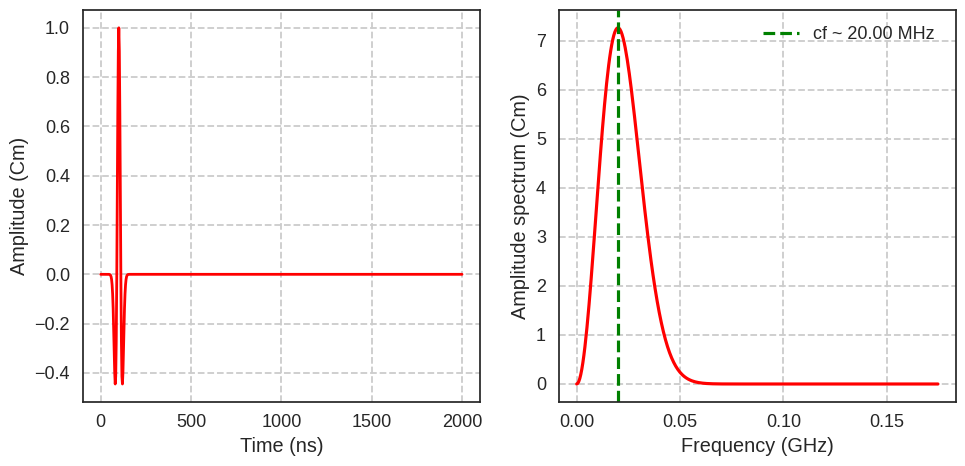

In [2]:
sou = SourceEM()
# sou.type='generalgamma'
sou.type='ricker'
# sou.set_source_params(a=3,
#                       c=1,
#                       loc=0,
#                       scale=0.01,
#                       ph=0)
sou.set_center_frequency(0.02)
sou.set_delay(100)
sou.set_time_vector(np.linspace(0,2000,701))
source = sou.create_source()
sou.export_to_hdf5(OUTPUT_DIR + 'FW_sim.h5', overwrite=True)
print(sou)
sou.plot_waveforms_complete()
# sou.plot_waveforms_zoom()


In [3]:
# We will define that the maximum element size is a fourth of the wavelength from our source function
c0 = 299_792_458  # Speed of light in m/s
rock_epsilon = 5.9  # Relative permitivity of the medium (dielectric constant)
velocity = c0 * 1e-9 / np.sqrt(rock_epsilon)  # To convert in m/ns
max_element_size = velocity / (sou.center_frequency * 6)
print(f'Element max size = {max_element_size:.2f} m')

Element max size = 1.03 m


## 2. Create a simple geometry <a class="anchor" id="2"></a>

In [4]:
# Create a simple geometry
frac = FractureGeo()
ver, _ = frac.create_regular_squared_mesh(width=10,
                                 length = 10,
                                 resolution = (10,10),
                                 dip = 80,
                                 azimuth = 180)

# import the obj file and remesh
import pyvista as pv
from fracwave import DATA_DIR
frac = FractureGeo()
folder = DATA_DIR + 'FEAR/AC/'
mc48 = pv.read(folder + 'Fault_48.obj')
mc49 = pv.read(folder + 'Fault_49.obj')
mc481 = pv.read(folder + 'Fault_48-1_new.obj')
# get the polydata from the pyvista polydata object 
# print(mc48.points)


2023/11/22 12:52:39 PM | INFO     | Fracture object loaded
2023/11/22 12:52:39 PM | INFO     | Fracture object loaded


/home/alexis/miniconda3/envs/fracwave/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


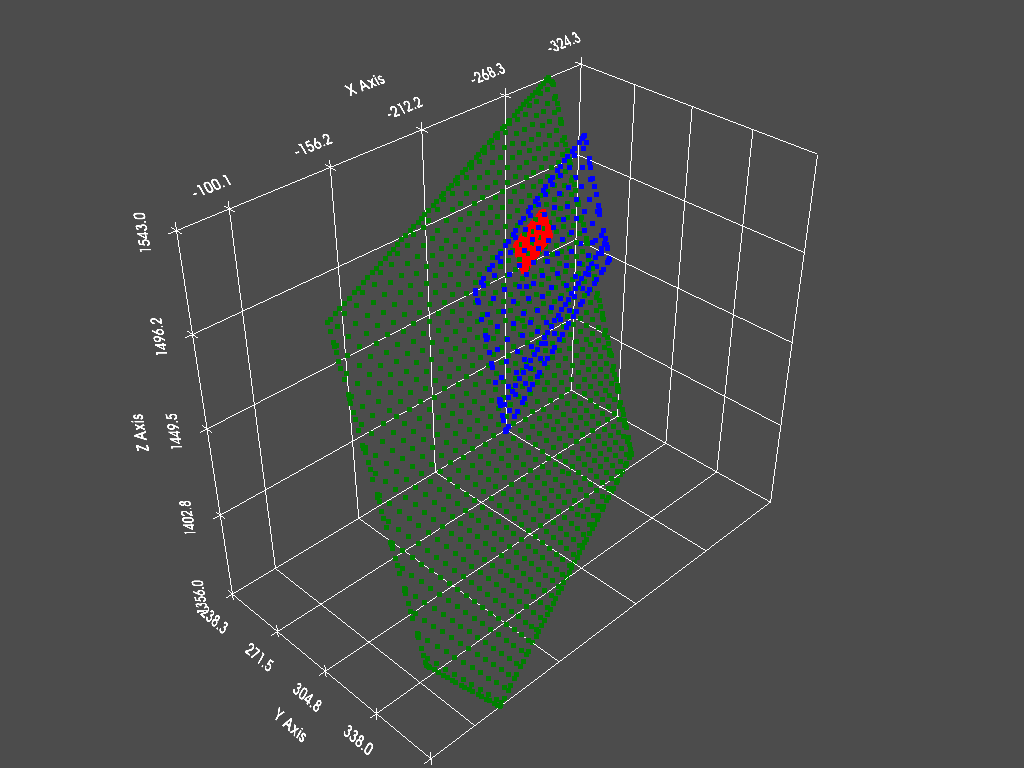

In [5]:
# Plot all imported meshes as pyvista pointclouds
p = pv.Plotter()
p.add_points(mc48.points, color='r')
p.add_points(mc49.points, color='b')
p.add_points(mc481.points, color='g')
p.show_grid()
p.show()


2023/11/22 12:52:40 PM | INFO     | Fracture object loaded
2023/11/22 12:52:40 PM | DEBUG    | horizontal resolution too big (10) setting to 200 ...
2023/11/22 12:52:40 PM | DEBUG    | vertical resolution too big (10) setting to 182 ...
2023/11/22 12:52:40 PM | DEBUG    | Meshing to resolution: [200, 182]...
2023/11/22 12:52:40 PM | DEBUG    | Meshing done
2023/11/22 12:52:40 PM | DEBUG    | Extracting vertices and faces...
2023/11/22 12:52:40 PM | DEBUG    | Extract done
2023/11/22 12:52:40 PM | DEBUG    | Faces set
2023/11/22 12:52:40 PM | DEBUG    | Vertices set
2023/11/22 12:52:40 PM | DEBUG    | Fracture MC set

        Fracture Geometry  2023-11-22 12:52
            number of fractures: 1
            number of elements: 35010
            surface area: 42,553.74 (m2)
        


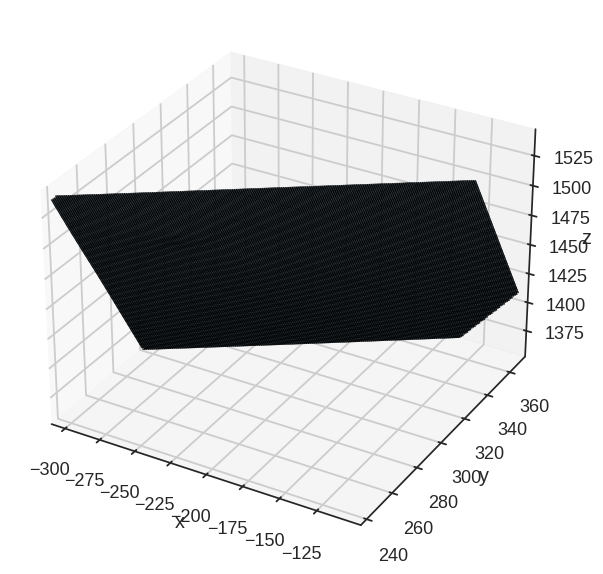

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [6]:
# import the obj file and remesh
import pyvista as pv
from fracwave import DATA_DIR
frac = FractureGeo()

plane = 1
grid, vertices, faces = frac.remesh(points=mc481.points,
                                    max_element_size=max_element_size,
                                    plane=plane,
                                    extrapolate=False,)
kwargs_electric_properties = dict(aperture=0.001, # in m
                                  electrical_conductivity=0, # in S/m
                                  electrical_permeability=81,
                                  )  # Unitless
frac.set_fracture(name_fracture='MC',
                  vertices=vertices,
                  faces=faces,
                  plane=plane,
                  overwrite=True,
                  **kwargs_electric_properties,)


print(frac)
frac.plot_geometry(backend='mpl')

In [7]:
frac.export_to_hdf5(OUTPUT_DIR + 'FW_sim.h5', overwrite=True)

2023/11/22 12:52:42 PM | INFO     | Overwriting existing "mesh" information
2023/11/22 12:52:42 PM | INFO     | File successfully saved in: /home/alexis/git/fracwave/output/FW_sim.h5


## 3. Create an antenna geometry <a class="anchor" id="3"></a>
We will create a simple dipole antenna

In [8]:
# load the borehole trajectories from csv files
from fracwave import DATA_DIR
import pandas as pd
folder_boreholes = DATA_DIR + 'FEAR/' 
borehole = pd.read_csv(folder_boreholes + 'BFE_A_05_borehole_information.csv')

# Assign Rx and Tx fo the borehole Easting, Northing and Elevation
BFE5_xyz = borehole[['Easting (m)', 'Northing (m)', 'Elevation (m)']].values
BFE_depth = borehole['Depth (m)'].values

# use only depths above and below certain values
BFE5_subset = BFE5_xyz[(BFE_depth > 10) & (BFE_depth < 60)]

# create a function to interpolate over the borehole trajectory and return the coordinates
from scipy.interpolate import interp1d
def borehole_interp(depth, borehole_depth, borehole_xyz):
    f = interp1d(borehole_depth, borehole_xyz, axis=0)
    return f(depth)


# get the orientation by making two depth vectors, one slightly shifted, and computing the vector between them
def get_orientation(depth, borehole_depth, borehole_xyz):
    xyz1 = borehole_interp(depth, borehole_depth, borehole_xyz)
    xyz2 = borehole_interp(depth + 0.1, borehole_depth, borehole_xyz)
    orientation = xyz2 - xyz1
    # get a normalized vector
    return orientation / np.linalg.norm(orientation, axis=1)[:, None]

traces = 500
# traces = 20
depth = np.linspace(0, 100, traces)
interpolated_xyz = borehole_interp(depth, BFE_depth, BFE5_xyz)
orientation = get_orientation(depth, BFE_depth, BFE5_xyz)

In [9]:
depth_Rx = np.linspace(depth.min(), depth.max(), traces)
depth_Tx = depth_Rx + 8

midpoints = (depth_Tx - depth_Rx) / 2 + depth_Rx

Rx = borehole_interp(depth_Rx, BFE_depth, BFE5_xyz)
Tx = borehole_interp(depth_Tx, BFE_depth, BFE5_xyz)

orient_tx =  get_orientation(depth_Rx, BFE_depth, BFE5_xyz)
orient_rx = get_orientation(depth_Tx, BFE_depth, BFE5_xyz)

In [10]:
ant = Antenna()
ant.set_profile(name_profile='Prof1',
                receivers=Rx,
                transmitters=Tx,
                orient_receivers=orient_rx,
                orient_transmitters=orient_tx,
                overwrite=True)

2023/11/22 12:52:42 PM | DEBUG    | Rx set
2023/11/22 12:52:42 PM | DEBUG    | Tx set
2023/11/22 12:52:42 PM | DEBUG    | orient_Rx set
2023/11/22 12:52:42 PM | DEBUG    | orient_Tx set



        Receiver-Transmitter  2023-11-22 12:52
            nprofiles: 1
            ntraces: 500
            
        


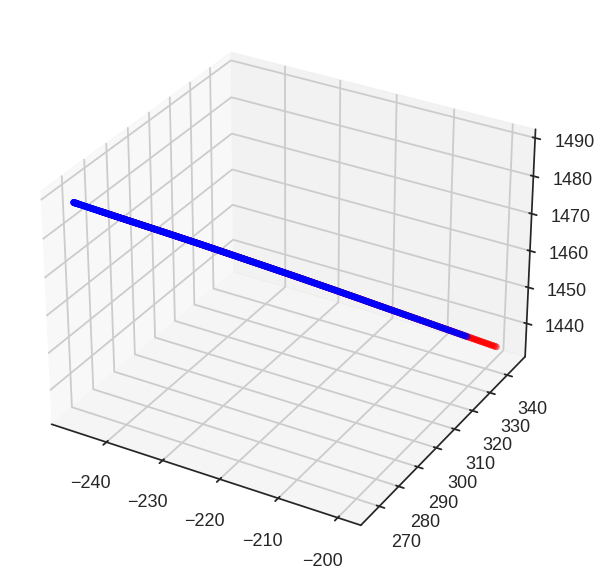

<Axes3D: >

In [11]:
print(ant)
ant.plot(backend='mpl')

In [12]:
ant.export_to_hdf5(OUTPUT_DIR + 'FW_sim.h5', overwrite=True)

2023/11/22 12:52:42 PM | INFO     | Overwriting existing "antenna" information
2023/11/22 12:52:42 PM | INFO     | File successfully saved in: /home/alexis/git/fracwave/output/FW_sim.h5



## 4. Visualize the geometry configuration <a class="anchor" id="4"></a>
Check the geometry and check if everything is ok.

In [13]:
# We can visualize the geometry configuration with pyvista
import pyvistaqt as pvqt

surf = frac.get_surface()
Tx, Rx, Tx_arrows, Rx_arrows = ant.get_geometry(show=False)

p = pvqt.BackgroundPlotter()
p.add_mesh(BFE5_xyz, color='black', opacity=1, show_edges=True)  
p.add_mesh(surf, color='white', opacity=0.5, show_edges=True)
p.add_mesh(Tx, color='red', point_size=10)
p.add_mesh(Rx, color='blue', point_size=10)
#p.add_mesh(Tx_arrows, color='red')
#p.add_mesh(Rx_arrows, color='blue')
p.export_html(OUTPUT_DIR + 'GPR_geometry_sim.html')

p.show_bounds()
p.show_axes()


## 5. Setup the parameters for the forward simulation <a class="anchor" id="5"></a>
To run the forward simulation successfully, you must create an instance of the FracEM class and load all the necessary parameters for the simulation. If any errors occur during the process, make sure to double-check the Antenna, Source, and Fracture geometries. Ensure that these geometries are correctly defined and saved in the same file to ensure smooth execution of the simulation.

In [14]:
solv = FracEM()
solv.open_file(OUTPUT_DIR + 'FW_sim.h5')
print(solv)  # Check that all the fields are loaded correctly

2023/11/22 12:52:49  | INFO     | File correctly loaded. Ready to start.
 
            Effective-Dipole model  2023-11-22 12:52
            Calculating in: "reflection" mode
            Using: "SI" units
            
            Backend computation:
                engine: tensor_trace
                backend: numpy
                gpu: False
            
            Rock properties:
                sigma: None (S/m) 
                epsilon: None (F/m)
                velocity: 0.00000 (m/ns)
                center_frequency: 20.00 MHz
                wavelength: 0.00 (m)
            
            Calculating for:
                no. Profiles: 1
                no. Traces: 500
                no. Fractures: 1
                no. Elements (dipoles): 35010
                no. Frequencies: 351
            
            Simulation:
                Time window: 2000.00 (ns)
                Depth penetration: 0.00 (m) 
                    or for single hole: 0.00 (m)
                Time zero

In [15]:
# Now we can play with the different parameters
# TODO: This probably will change in the future but for now just replace the following values
solv.rock_epsilon = 5.9  # Electrical permittivity of the medium
solv.rock_sigma = 0  # Electrical conductivity of the medium
solv.backend = 'torch'  # You can choose between cupy, torch, numpy or dask (dask is for running parallel but maybe not working correctly). Cupy is to run in GPU. Numpy and torch are the most stable ones. We suggest to run torch since is the fastest one.
solv.engine='tensor_trace'  # This is the engine that will be used to compute the simulation. Is also the most stable one. Don't try to choose another option if you are not sure what you are doing
solv.mode = 'reflection' # you can change to ['transmission', 'reflection', 'full_reflection', 'incoming_field', 'dipole_response', 'propagation'] depending on what you want to calculate
# 'propagation' is to calculate the propagation of the field to the fracture 
solv.apply_causality = True # This is to check that the computations are inside the time window we are looking for. This means that it will filter out all those fracture elements that are too far from the antennas and will not show in the time window. Not calculating if _fast_calcualtion_incoming_field is False
solv.filter_fresnel = False # This is to check that the computations are inside the time window we are looking for. This means that it will filter out all those fracture elements that are too far from the antennas and will not show in the time window. Not calculating if _fast_calcualtion_incoming_field is False

solv.filter_energy = False  # Here we focus on studying the incoming field on the fracture for a specific frequency and examine the propagating energy. To achieve this, we 
# apply a filtering process that eliminates the lower n% of energy across all fracture elements. This selective approach allows us to reduce computation time by excluding elements that have minimal impact on the final results.

solv._filter_percentage = 0.01  # This means that during the energy filtering process, any elements whose energy level is at or below 1% of the maximum energy among all elements will be excluded from our computation. By adjusting this filter percentage, we can control the level of filtering and fine-tune the simulation to strike a balance between computational efficiency and accuracy.


2023/11/22 12:52:49  | INFO     | 
Operative system: Linux 
Model name :  AMD Ryzen 7 PRO 5850U with Radeon Graphics 
    CPU core(s): 16
    Processes: 4
    Threads: 4
Memory:
    Total: 30.18 GiB
    Available: 15.96 GiB
    Used: 13.52 GiB (47.1%)
    Free: 7.42 GiB



## 6. Time zero correction <a class="anchor" id="6"></a>
To compensate for the time delay in our source function and achieve precise results, we implement a time zero correction. This process entails running a forward simulation, analyzing the time response, and comparing it to the actual distance. The entire correction process is automated, and the corrected time data is stored for future use. This corrected time will be employed to adjust the time vector in future simulations.


2023/11/22 12:52:50  | DEBUG    | Rx set
2023/11/22 12:52:50  | DEBUG    | Tx set
2023/11/22 12:52:50  | DEBUG    | orient_Rx set
2023/11/22 12:52:50  | DEBUG    | orient_Tx set
2023/11/22 12:52:50  | INFO     | Overwriting existing "antenna" information
2023/11/22 12:52:50  | INFO     | File successfully saved in: /home/alexis/git/fracwave/data/time_correction/file.h5
2023/11/22 12:52:50  | INFO     | 
Operative system: Linux 
Model name :  AMD Ryzen 7 PRO 5850U with Radeon Graphics 
    CPU core(s): 16
    Processes: 4
    Threads: 4
Memory:
    Total: 30.18 GiB
    Available: 15.97 GiB
    Used: 13.51 GiB (47.1%)
    Free: 7.44 GiB

2023/11/22 12:52:50  | INFO     | Propagation mode is selected. Geometry is not needed
2023/11/22 12:52:50  | INFO     | File correctly loaded. Ready to start.
 
            Time zero correction  2023-11-22 12:52
            Calculating in: "propagation" mode
            Using: "SI" units
            
            Backend computation:
                engi

  0%|          | 0/4 [00:00<?, ?it/s]

2023/11/22 12:52:50  | INFO     | ++++ "propagation" mode finished ++++
2023/11/22 12:52:50  | INFO     | 
+++++++++++++++++++++ End simulation +++++++++++++++++++++

+++++++++++++++++++++ Time elapsed: 0:00:00.083923 +++++++++++++++++++++

2023/11/22 12:52:50  | INFO     | No time zero correction


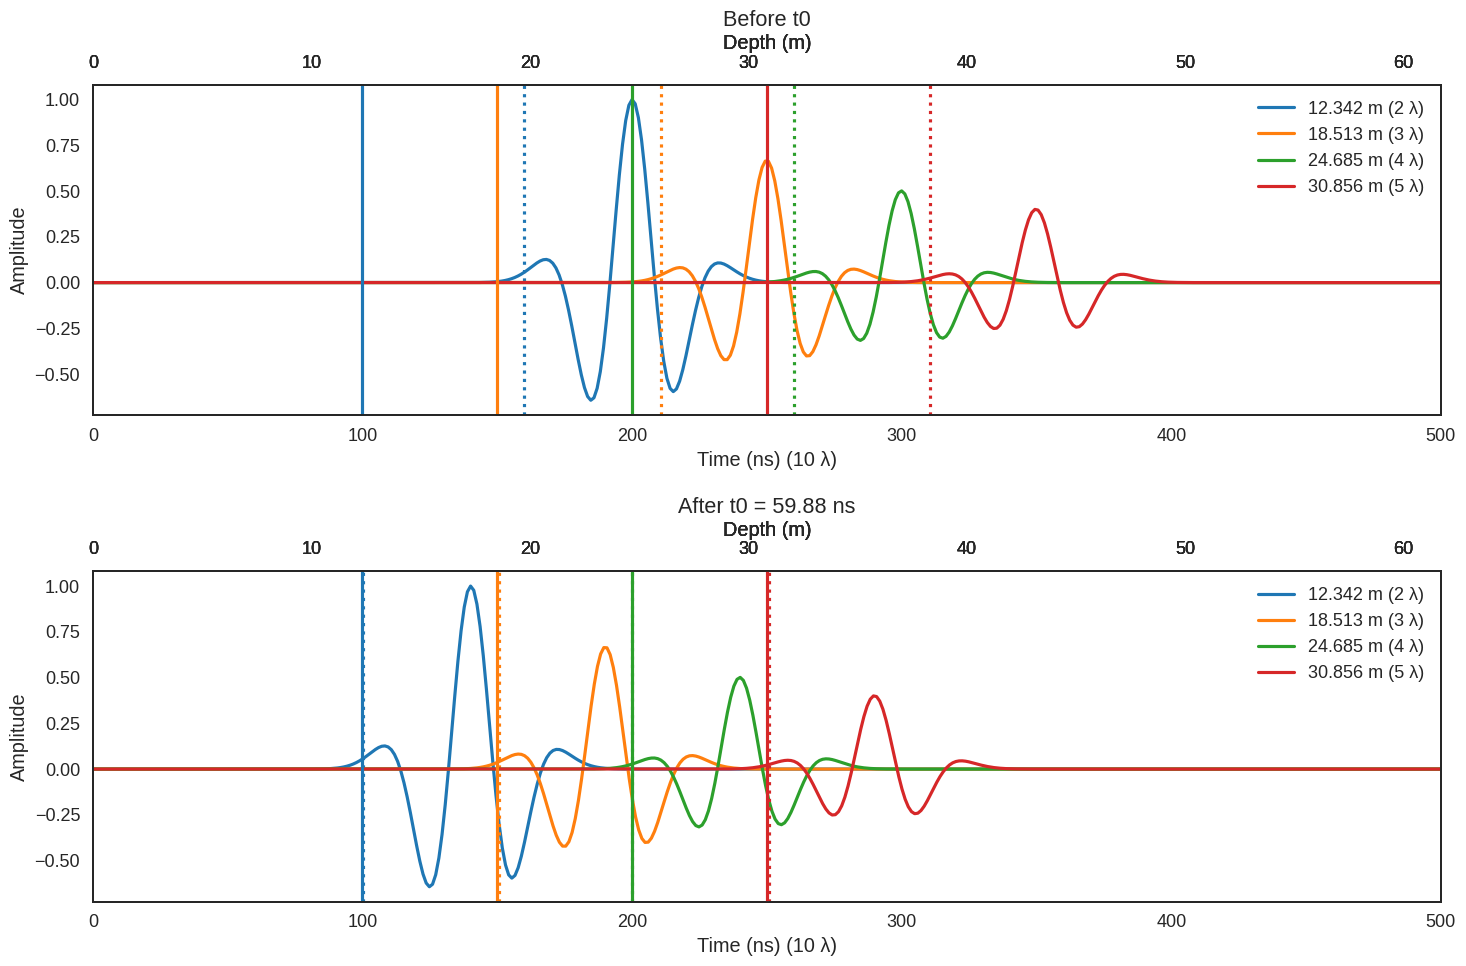

2023/11/22 12:52:53  | INFO     | "t0_correction" attribute created with 59.88 ns to remove

++++ 
We need to remove 59.88 ns to account for the time delay introduced when setting the source function 
++++ 



In [16]:
freqt = solv.time_zero_correction()
# if any errors, try adding a bigger time delay to the source function
print(f'\n++++ \nWe need to remove {solv._t0_correction:.2f} ns to account for the time delay introduced when setting the source function \n++++ \n')

## 7. Run the forward simulation <a class="anchor" id="7"></a>
Now we can run the forward simulation. This will take a while depending on the number of frequencies and the number of elements in the fracture. We have implemented a progress bar to see the progress of the simulation. 

In [17]:
freq = solv.forward_pass()

2023/11/22 12:52:53  | INFO     | 
+++++++++++++++++++++ Start Simulation +++++++++++++++++++++

2023/11/22 12:52:53  | INFO     | "simulation" attributes created
2023/11/22 12:52:53  | INFO     | Starting calculation for 500 amount of traces
2023/11/22 12:52:53  | DEBUG    | +++Calculating the mask at the fracture field+++
2023/11/22 12:52:53  | DEBUG    | Using 27 frequencies out of 351 possible


  0%|          | 0/500 [00:00<?, ?it/s]

2023/11/22 12:53:07  | INFO     | Using 154 frequencies out of 351 possible frequencies


  0%|          | 0/500 [00:00<?, ?it/s]

/home/alexis/git/fracwave/fracwave/solvers/fracEM/solver_EM.py:457: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = arr.tensor(sigma)


2023/11/22 01:49:02  | INFO     |  ------- End of Calculation. Elapsed time: 0:56:08.913389 ------- 
2023/11/22 01:49:02  | INFO     | 
+++++++++++++++++++++ End simulation +++++++++++++++++++++

+++++++++++++++++++++ Time elapsed: 0:56:09.092090 +++++++++++++++++++++



## 8. Check results <a class="anchor" id="8"></a>
As we perform all calculations in the frequency domain, it's essential to convert the results back to the time domain. This transformation is achieved using the inverse Fourier transform. To simplify this process and apply the time zero correction, we have created a user-friendly function that handles both operations seamlessly. The time vector contains the corrected time vector accounting for the time correction. 

In [24]:
time_response, time_vector = solv.get_ifft(freq)

2023/11/22 01:50:24  | INFO     | Applying time zero correction to data. Removing 59.88 ns from data


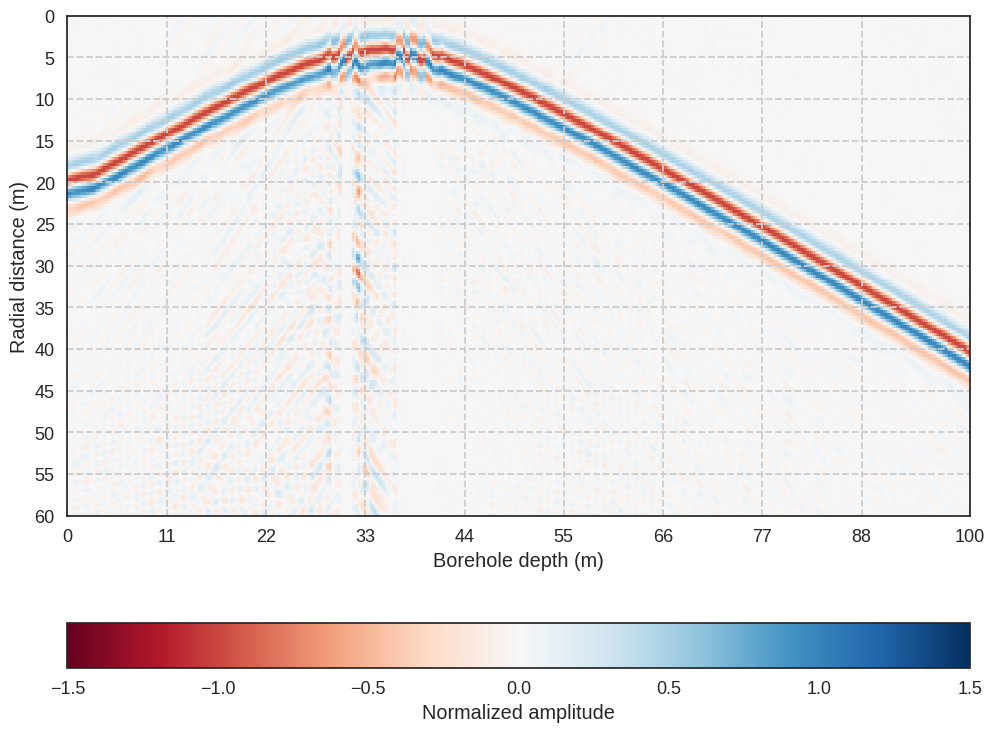

In [57]:
# Now we can visualize using matplotlib
time_response_n = time_response.T /  np.max(np.abs(time_response),axis=1)
fig, ax = plt.subplots(1,1, figsize=(10,8))
y_shift = 8


extent = (depth.min(), 
          depth.max(), 
          time_vector[-1]* solv.velocity - y_shift,
          time_vector[0]* solv.velocity - y_shift)
cax = ax.imshow(time_response_n, aspect='auto', cmap='RdBu', extent=extent, vmin=-1.5, vmax=1.5, interpolation='None')
ax.set_xlabel('Borehole depth (m)')
ax.set_ylabel('Radial distance (m)')

# ylims_d = (max(ylims)* solv.velocity * 0.5, min(ylims)* solv.velocity * 0.5)
# ylims_d = (max(ylims)* solv.velocity * 0.5, min(ylims)* solv.velocity * 0.5)
ylims_d = (time_vector[-1]* solv.velocity - y_shift, time_vector[0]* solv.velocity - y_shift)

ax.xaxis.set_ticks(np.linspace(depth.min(), depth.max(), 10, dtype=int))

d_ticks = np.round(np.linspace(min(ylims_d), max(ylims_d), 50), 0)
ax.yaxis.set_ticks(d_ticks)

#ax.tick_params(axis='both', which='both', direction='out', length=5)

ax.grid(linestyle='--')
ax.set_ylim(60, 0)

plt.tight_layout(pad=0.5)
plt.colorbar(cax, ax=ax, label='Normalized amplitude', orientation='horizontal')
plt.savefig(OUTPUT_DIR + 'GPR_simulation_MC.png', dpi=300)
plt.show()


(119.72718385022512, -3.6954178994460394)


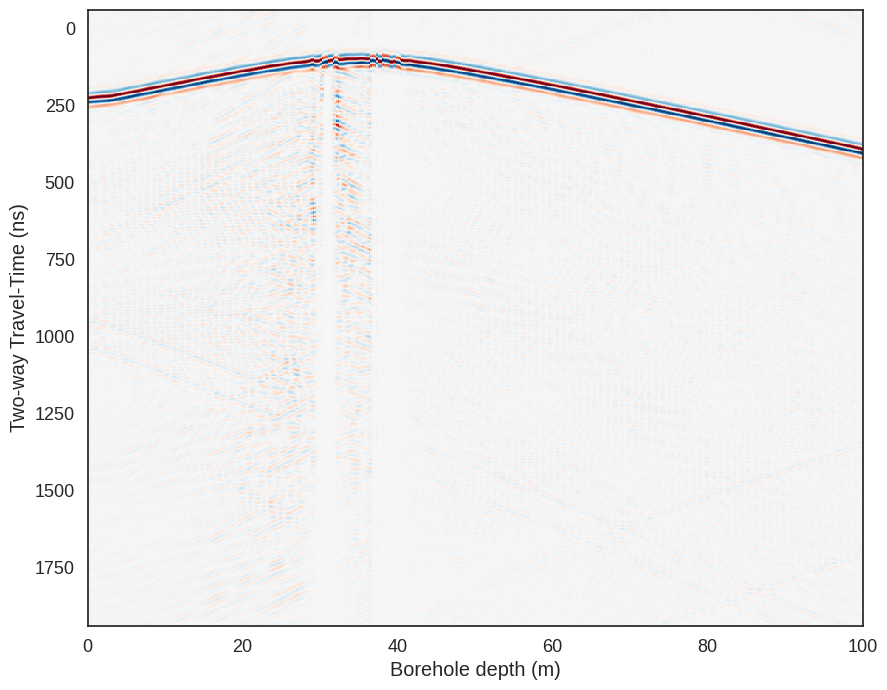

In [32]:
# Now we can visualize using matplotlib
time_response_n = time_response.T /  np.max(np.abs(time_response),axis=1)
fig, ax = plt.subplots(1,1, figsize=(10,8))

extent = (depth.min(), depth.max(), time_vector[-1], time_vector[0])
cax = ax.imshow(time_response_n, aspect='auto', cmap='RdBu', extent=extent, vmin=-1, vmax=1, interpolation='None')
ax.set_xlabel('Borehole depth (m)')
ax.set_ylabel('Two-way Travel-Time (ns)')

# ylims_d = (max(ylims)* solv.velocity * 0.5, min(ylims)* solv.velocity * 0.5)
ylims_d = (time_vector[-1]* solv.velocity / 2, time_vector[0]* solv.velocity / 2)
print(ylims_d)

## 9. Save results <a class="anchor" id="9"></a>
The good news is that once you complete the forward calculation, the results are automatically saved. You can easily access and verify the saved files to ensure the data is there. Additionally, if you wish to revisit the results or perform further analysis, you have the option to load the saved data and plot it again. This flexibility enables you to conveniently review and explore the simulation outcomes whenever you need them.

In [20]:
solv = FracEM()
solv.load_hdf5(OUTPUT_DIR + 'FW_sim.h5')
print(solv)

2023/11/22 01:49:02  | INFO     | Loading file...
2023/11/22 01:49:02  | INFO     | File correctly loaded. Ready to start.
 
            Effective-Dipole model  2023-11-22 13:49
            Calculating in: "reflection" mode
            Using: "SI" units
            
            Backend computation:
                engine: tensor_trace
                backend: numpy
                gpu: False
            
            Rock properties:
                sigma: None (S/m) 
                epsilon: None (F/m)
                velocity: 0.00000 (m/ns)
                center_frequency: 20.00 MHz
                wavelength: 0.00 (m)
            
            Calculating for:
                no. Profiles: 1
                no. Traces: 500
                no. Fractures: 1
                no. Elements (dipoles): 35010
                no. Frequencies: 351
            
            Simulation:
                Time window: 2000.00 (ns)
                Depth penetration: 0.00 (m) 
                    or f

Loading all the information from the h5 file is remarkably convenient. Not only does it include the data, but also the attributes from all the geometry, antennas, sources, and simulation settings. This approach allows you to retrieve and access all the necessary details effortlessly, providing a seamless experience for reviewing and utilizing the simulation data.

In [21]:
freq2 = solv.file_read('summed_response')
assert np.allclose(freq, freq2), 'The results are not the same'

In [22]:
# You can conveniently see all the file structure here and load them in the same way.
solv.h5_tree()

Geometry files


<HDF5 file "FW_sim.h5" (mode r)>
├── antenna [Group] (5 items)
│   ├── Rx [Dataset: (500, 3)]
│   ├── Tx [Dataset: (500, 3)]
│   ├── orient_Rx [Dataset: (500, 3)]
│   ├── orient_Tx [Dataset: (500, 3)]
│   └── profiles [Group] (1 items)
│       └── Prof1 [Dataset: (500,)]
├── mesh [Group] (2 items)
│   ├── geometry [Group] (8 items)
│   │   ├── area [Dataset: (35010,)]
│   │   ├── azimuth [Dataset: (35010,)]
│   │   ├── dip [Dataset: (35010,)]
│   │   ├── faces [Dataset: (35010, 4)]
│   │   ├── fractures [Group] (1 items)
│   │   │   └── MC [Dataset: (35010,)]
│   │   ├── midpoint [Dataset: (35010, 3)]
│   │   ├── nz [Dataset: (35010, 3)]
│   │   └── vertices [Dataset: (35392, 3)]
│   └── properties [Group] (3 items)
│       ├── aperture [Dataset: (35010,)]
│       ├── elec_conductivity [Dataset: (35010,)]
│       └── elec_permeability [Dataset: (35010,)]
└── source [Group] (6 items)
    ├── freq_vector [Dataset: (701,)]
    ├── freq_waveform [Dataset: (701,)]
    ├── f

In [23]:
# If you want to load an specific attribute you can do it like this
solv.file_read_attribute('engine')  # We can skip the full path of the attribute as long it is not repeated in the file. Otherwise just use the full path 'simulation/engine'

'tensor_trace'